<a href="https://colab.research.google.com/github/FelipeH22/kernels_svms_n_logreg/blob/main/kernels_svms_n_logreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## String kernels for SVM

In [ ]:
import requests
import unidecode
import pandas as pd
from sklearn.svm import SVC
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
english_url = "https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/English/Wikipedia_(2016)"
spanish_url = "https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/Spanish/Mixed_730K"

The following cell extracts the words from the webpages omitting certain tags and characters that could be retrieved when performing the web scraping. Posible accents and other characters are removed

(english words)

In [ ]:
response = requests.get(english_url)
html = BeautifulSoup(response.text, 'html.parser')
tags = html.find_all("a")
english_words = list(set([unidecode.unidecode(tag.text).lower() for tag in tags
                 if len(tag.text) > 3 and " " not in tag.text
                 and ":/" not in tag.text and "-" not in tag.text]))

(spanish words)

In [ ]:
response = requests.get(spanish_url)
html = BeautifulSoup(response.text, 'html.parser')
tags = html.find_all("a")
spanish_words = list(set([unidecode.unidecode(tag.text).lower() for tag in tags
                 if len(tag.text) > 3 and " " not in tag.text
                 and ":/" not in tag.text and "-" not in tag.text]))

In [ ]:
english_words = pd.DataFrame({"words": english_words, "label": [0 for _ in range(len(english_words))]})
print(english_words.shape)
english_words.head(3)

(8581, 2)


,words,label
0,collisions,0
1,lightning,0
2,started,0


In [ ]:
spanish_words = pd.DataFrame({"words": spanish_words, "label": [1 for _ in range(len(spanish_words))]})
spanish_words = spanish_words.sample(english_words.shape[0])
print(spanish_words.shape)
spanish_words.head(3)

(8581, 2)


,words,label
1512,emplea,1
708,dioses,1
8476,viajo,1


English and spanish words are put together in a dataframe. A sample is performed in order to use only the half of the data because of the computational resources available and to make the execution time manageable

In [ ]:
words = pd.concat([english_words, spanish_words])
words = words.sample(frac=.5)
words.head(10)

,words,label
2785,burn,0
2142,friendship,0
8061,postwar,0
4646,vigentes,1
2912,going,0
3526,shifts,0
7904,lesiones,1
3702,persian,0
5112,targeting,0
3376,chen,0


Data is split into train (80%) and test (20%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(words["words"].to_numpy(), words['label'].to_numpy(), test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6864,), (6864,), (1717,), (1717,))

Function that take training dataset as an input and train a SVM using the kernel sent as an argument. Grid search is implemented varying the C value in $\{2x10^{-5}, 2x10^{-4}, ..., 2x10^{5}\}$ and Cross Validation. The results are shown in a plot and the best estimator and the vectorizer are returned

In [ ]:
def vectorize_n_train(X_train, y_train, kernel, ngram_rg=(1, 1)):
  vectorizer = CountVectorizer(analyzer='char', ngram_range=ngram_rg)
  X = vectorizer.fit_transform(X_train)
  # Training using CV and kernel provided
  support_machine = SVC()
  clf = GridSearchCV(support_machine, {"kernel":[kernel],
                                      "C": [2*(10**(i)) for i in range(-5, 5)]},
                    return_train_score=True, refit=True)
  clf.fit(X.toarray(), y_train)
  plt.plot([2*(10**(i)) for i in range(-5, 5)], clf.cv_results_["mean_test_score"], label="test_acc")
  plt.plot([2*(10**(i)) for i in range(-5, 5)], clf.cv_results_["mean_train_score"], label="train_acc")
  plt.xlabel("C")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()
  best_estimator = clf.best_estimator_
  return best_estimator, vectorizer

Best estimator and plot for cosine_similiarity kernel

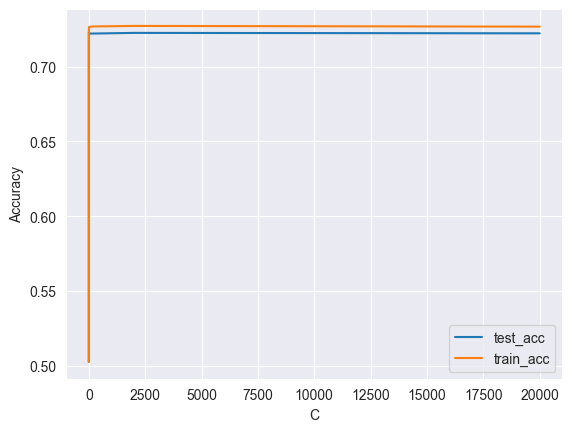

In [ ]:
cosine_sim_estimator, vectorizer = vectorize_n_train(X_train, y_train, cosine_similarity)

Best estimator and plot for chi_square kernel

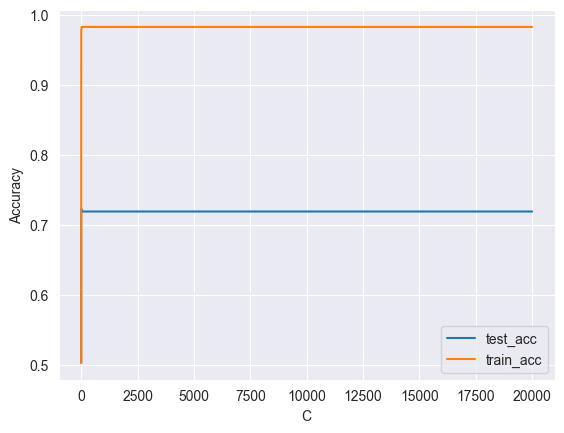

In [ ]:
chi_estimator, vectorizer_chi = vectorize_n_train(X_train, y_train, chi2_kernel)

In [ ]:
y_pred = chi_estimator.predict(vectorizer_chi.transform(X_test).toarray())
chi_acc = accuracy_score(y_test, y_pred)

n-grams representation normalized

In [ ]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 2))
X = vectorizer.fit_transform(X_train).toarray()
X = X / X.sum(axis=1, keepdims=True)
sum_of_minimums = X.min(axis=0).sum()
print(f"Bag of n-grams representation normalized:\n{X}\nwith shape {X.shape}")
print(f"Sum of minimums for each bin: {sum_of_minimums}")

Bag of n-grams representation normalized:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
with shape (6864, 29)
Sum of minimums for each bin: 0.0


## MNIST two-digits classifier (SVM)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [ ]:
sns.set_theme()

In order to download the data, the following cell is executed.

Data will be stored in two variables X and y and the shapes are shown at the cell output

In [ ]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X.shape, y.shape

((70000, 784), (70000,))

For training and testing data split, the following cells are defined, the test dataset corresponds to 20% of the whole data obtained  

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

The images' pixels are rescaled in order to obtain smaller values. They are standarized (mean 0 and std 1)using the StandardScaler method and applied to the train dataset and test dataset.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Since the classification is intended only between two digits, a function is built in order to extract them filtering by the d1 and d2 arguments.

In [ ]:
def get_two_digits(x_train, x_test, label_train, label_test, d1, d2):
  d1_train_index = np.where(label_train == str(d1))
  d1_test_index = np.where(label_test == str(d1))
  d2_train_index = np.where(label_train == str(d2))
  d2_test_index = np.where(label_test == str(d2))
  X_train_d1, X_test_d1, y_train_d1, y_test_d1 = (x_train[d1_train_index],
                                             x_test[d1_test_index],
                                             label_train[d1_train_index],
                                             label_test[d1_test_index])
  X_train_d2, X_test_d2, y_train_d2, y_test_d2 = (x_train[d2_train_index],
                                             x_test[d2_test_index],
                                             label_train[d2_train_index],
                                             label_test[d2_test_index])
  new_X_train = np.append(X_train_d1, X_train_d2, 0)
  new_y_train = np.append(y_train_d1, y_train_d2, 0)
  new_X_test = np.append(X_test_d1, X_test_d2, 0)
  new_y_test = np.append(y_test_d1, y_test_d2, 0)

  return new_X_train, new_y_train, new_X_test, new_y_test

In [ ]:
new_X_train, new_y_train, new_X_test, new_y_test = get_two_digits(X_train, X_test, y_train, y_test, 3, 6)
new_X_train.shape, new_y_train.shape, new_X_test.shape, new_y_test.shape

((11223, 784), (11223,), (2794, 784), (2794,))

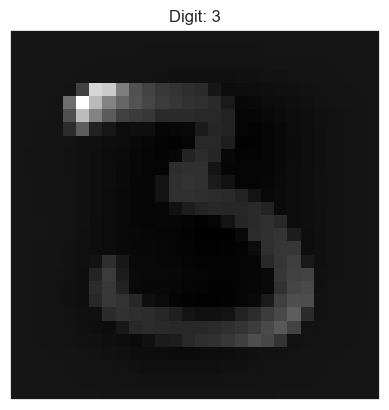

In [ ]:
first_class_example = np.where(new_y_train == '3')[0][2]
plt.imshow(new_X_train[first_class_example].reshape(28,28), cmap="gray")
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title(f"Digit: {new_y_train[first_class_example]}")
plt.show()

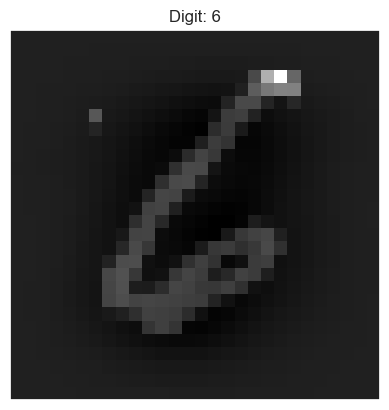

In [ ]:
second_class_example = np.where(new_y_train == '6')[0][2]
plt.imshow(new_X_train[second_class_example].reshape(28,28), cmap="gray")
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title(f"Digit: {new_y_train[second_class_example]}")
plt.show()

The cross validation is built using grid search and its corresponding sklearn function defining the kernel as linear and varying the C value between the $\{2x10^{-15}, 2x10^{-14}, ..., 2x10^{10}\}$ values and setting specific parameters for the method like returning the training score for plotting the score later and also the refit parameter in order to refit the best estimator (with the hyperparameters that got the best performance) with the whole training dataset (because of the cross validation training-validation automatic split).

In [ ]:
support_machine = SVC()
clf = GridSearchCV(support_machine, {"kernel":[ "linear"],
                                     "C": [2*(10**(i)) for i in range(-15, 10)]},
                   return_train_score=True, refit=True)

In [ ]:
clf.fit(new_X_train, new_y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [2e-15, 2e-14, 2e-13, 2e-12, 2e-11, 2e-10, 2e-09,
                               2e-08, 2e-07, 2e-06, 2e-05, 0.0002, 0.002, 0.02,
                               0.2, 2, 20, 200, 2000, 20000, 200000, 2000000,
                               20000000, 200000000, 2000000000],
                         'kernel': ['linear']},
             return_train_score=True)

All of the results obtained in the grid search with cross validation are shown below

In [ ]:
clf.cv_results_

{'mean_fit_time': array([28.97628732, 29.15206709, 30.995999  , 30.9425179 , 30.54514179,
        30.52254415, 31.31037121, 31.09852724, 32.03824577, 26.64950585,
         8.35636539,  2.74168787,  1.29639587,  0.93342004,  0.85475078,
         0.87904868,  0.87142572,  0.85093565,  0.8800715 ,  0.88890743,
         0.84807868,  0.90279756,  0.92152333,  0.90789127,  0.81577134]),
 'std_fit_time': array([1.37643905, 1.26304107, 0.5236948 , 0.68222967, 0.73335602,
        0.84550364, 0.63740315, 0.9572037 , 1.26379674, 0.53755487,
        0.13855427, 0.11637301, 0.10201344, 0.04378441, 0.07567088,
        0.06530389, 0.05319378, 0.0173934 , 0.03399772, 0.04709661,
        0.07821185, 0.05692551, 0.09085133, 0.04969029, 0.04198835]),
 'mean_score_time': array([6.33731904, 6.13279972, 6.39727101, 6.67501488, 6.3608161 ,
        6.6674511 , 6.70359192, 6.63352151, 7.01568451, 5.6418632 ,
        1.95436749, 0.58980927, 0.09166517, 0.0541399 , 0.05590358,
        0.0472867 , 0.04927249, 0.0

In [ ]:
best_model = clf.best_estimator_

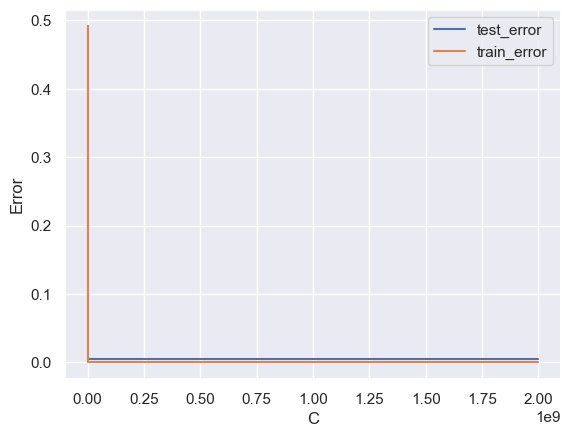

In [ ]:
plt.plot([2*(10**(i)) for i in range(-15, 10)], 1-clf.cv_results_["mean_test_score"], label="test_error")
plt.plot([2*(10**(i)) for i in range(-15, 10)], 1-clf.cv_results_["mean_train_score"], label="train_error")
plt.xlabel("C")
plt.ylabel("Error")
plt.legend()
plt.show()

Accuracy score of the best estimator over the test dataset

In [ ]:
y_pred = best_model.predict(new_X_test)
accuracy_score(new_y_test, y_pred)

0.9971367215461704

Model weights extraction

In [ ]:
weights = best_model.coef_

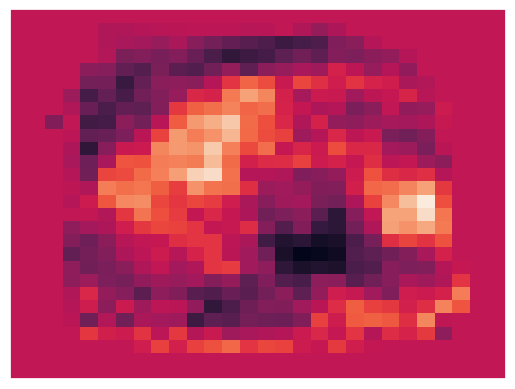

In [ ]:
plt.pcolor(weights.reshape(28, 28));
plt.xticks([]);
plt.yticks([]);

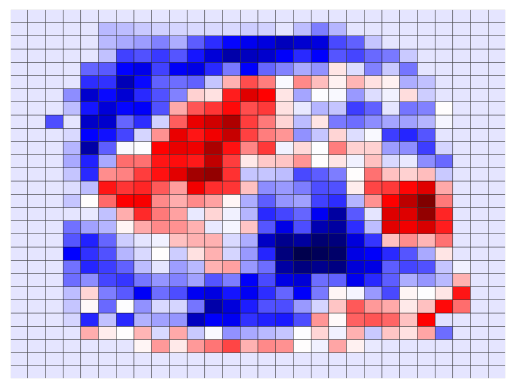

In [ ]:
plt.pcolor(weights.reshape(28, 28), edgecolors='k', cmap="seismic");
plt.xticks([]);
plt.yticks([]);

The obtained weights correspond to a 784-element array, one element for each pixel in the images. Reshaping this array into a 28x28 matrix could provide insight into how the classifier assigns weights to individual pixels for each image.

The visualized representation of the matrix shown above aligns with our expectations. Pixels representing key features for distinguishing a "3" from a "6" show high intensity. Specifically, the intensity is high in areas corresponding to the left "arms" of a "3" and the pixels of a three that could indeed fill the empty circle of a number 6 which is one of the main features that make the 6 distinguishable from the 3

Now lets try the same experiment with another digits, in this case, building a classifier to distinguish between number "0" and number "1"

In [ ]:
digit1 = 0
digit2 = 1

In [ ]:
new_X_train, new_y_train, new_X_test, new_y_test = get_two_digits(X_train, X_test, y_train, y_test, digit1, digit2)
new_X_train.shape

(11809, 784)

In [ ]:
support_machine = SVC()
clf = GridSearchCV(support_machine, {"kernel":[ "linear"],
                                     "C": [5*(10**(i)) for i in range(-5, 5)]},
                   return_train_score=True, refit=True)

In [ ]:
clf.fit(new_X_train, new_y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [5e-05, 0.0005, 0.005, 0.05, 0.5, 5, 50, 500,
                               5000, 50000],
                         'kernel': ['linear']},
             return_train_score=True)

In [ ]:
clf.cv_results_

{'mean_fit_time': array([2.68307428, 0.82636895, 0.44810772, 0.41008515, 0.440347  ,
        0.38952184, 0.3985992 , 0.38898816, 0.40349045, 0.39814215]),
 'std_fit_time': array([0.0866823 , 0.04475338, 0.02800328, 0.0227659 , 0.04867684,
        0.00996059, 0.02858144, 0.03933765, 0.04719919, 0.0399322 ]),
 'mean_score_time': array([0.49037695, 0.05803752, 0.04197493, 0.02145224, 0.03051744,
        0.01911755, 0.03281407, 0.02944384, 0.02714291, 0.02784753]),
 'std_score_time': array([0.03297022, 0.00642707, 0.01089103, 0.00585441, 0.00687232,
        0.00360916, 0.00423093, 0.00754575, 0.00527899, 0.00735204]),
 'param_C': masked_array(data=[5e-05, 0.0005, 0.005, 0.05, 0.5, 5, 50, 500, 5000,
                    50000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'linear', 'linear', 'linear', 'linear',
                   

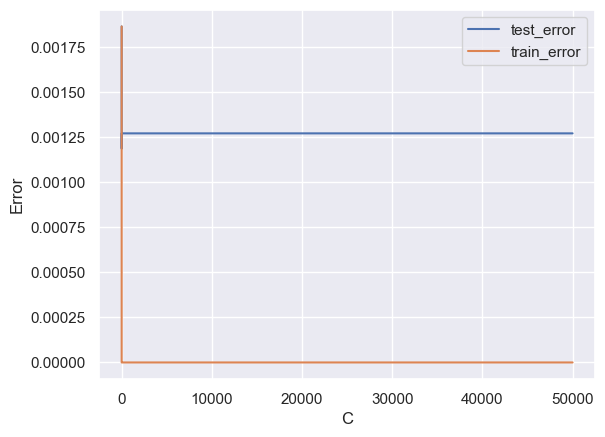

In [ ]:
plt.plot([5*(10**(i)) for i in range(-5, 5)], 1-clf.cv_results_["mean_test_score"], label="test_error")
plt.plot([5*(10**(i)) for i in range(-5, 5)], 1-clf.cv_results_["mean_train_score"], label="train_error")
plt.xlabel("C")
plt.ylabel("Error")
plt.legend()
plt.show()

In [ ]:
weights = clf.best_estimator_.coef_

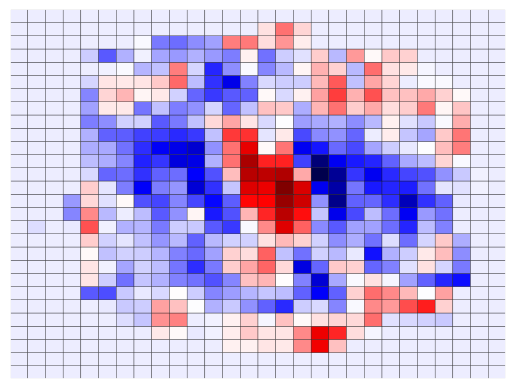

In [ ]:
plt.pcolor(weights.reshape(28, 28), edgecolors='k', cmap="seismic");
plt.xticks([]);
plt.yticks([]);

Once again, the visual representation of the weight provide an insight on how the classifier works at a pixel level within the images. In this case, the number 0 is very much distinguished because of the big void in the center of it, so the pixels that could fill that empty space instantly provide a big likelihood that the number in the image is not a 0 which corresponds visually in the weights to the brightest red pixels in the whole image.  

## Kernelized Logistic Regression (from scratch)

In order to rewrite the discriminant function in terms of the coefficients $\alpha_i$ and the kernel, the following algebra is applied  

<p align=center>
$
f(x) = \sigma(w\phi(x))
$
<br>
$
f(x) = \sigma(\sum\limits_{i=1}^l \alpha_i\phi(x_i))(\phi(x))
$
<br>
$
f(x) = \frac{1}{1+e^{-\sum\limits_{i=1}^l \alpha_i \phi(x_i)\phi(x)}}
$
<br>
$
f(x) = \frac{1}{1+e^{-\sum\limits_{i=1}^l \alpha_i K(x_i, x)}}
$
</p>

In the last step it can be seen that the whole function is now rewritten in terms of the coefficients and the kernel. The kernel is obtained because of the expression in step 3, where the expression $\phi(x_i)\phi(x)$ correspond to the kernel

The whole optimization problem now consists of minimizing the loss, in this case, binary cross entropy, that can be defined as shown here after replacing the predicted value with the objective function which at the end is the predicted value

<p align=center>
$
\min\limits_{\alpha} L_{CE}(\textbf{y}, \hat{\textbf{y}})
$
</p>

<p align=center>
$
L_{CE}(\textbf{y}, \hat{\textbf{y}}) = - \sum\limits_{j=1}^N\left(y_i \cdot log\left(\frac{1}{1+e^{-\sum\limits_{i=1}^l \alpha_i K(x_i, x)}}\right) + (1- y_i) \cdot log\left(1 - \frac{1}{1+e^{-\sum\limits_{i=1}^l \alpha_i K(x_i, x)}}\right) \right)
$
</p>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.pipeline import make_pipeline
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

The first approach for implementing the regression was extending the BaseEstimator scikit-learn class in order to use some other internal functions like plotting the decision regions. However, even though the definition is well-defined and worked fine with the fit, predict and score, it did not work with the DecisionBoundaryDisplay.from_estimator method so the definition remained the same, but it is not used in any other internal sklearn's method

In [ ]:
class logistic(BaseEstimator, ClassifierMixin):
  def __init__(self, kernel_function):
    self.kernel_func = kernel_function
    self.alphas = None
    self.kernel_train = None

  def objective_function(self, alpha, K, y):
    predictions = 1 / (1 + np.exp(-np.dot(alpha, K)))
    loss = - np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    return loss

  def fit(self, X, y):
    self.X_train = X
    N, D = X.shape
    self.kernel_train = np.zeros((N, N))
    for i in range(N):
      for j in range(N):
        self.kernel_train[i, j] = self.kernel_func(X[i], X[j])
    alphas = np.zeros(N)
    result = minimize(self.objective_function, alphas, args=(self.kernel_train, y), method='BFGS')
    self.alphas = result.x
    return self

  def predict(self, X_test):
    M, _ = X_test.shape
    K_test = np.zeros((M, self.kernel_train.shape[0]))
    for i in range(M):
      for j in range(self.kernel_train.shape[0]):
        K_test[i, j] = self.kernel_func(X_test[i], self.X_train[j])
    predictions = 1 / (1 + np.exp(-np.dot(self.alphas, K_test.T)))
    binary_predictions = (predictions > 0.5).astype(int)
    return binary_predictions

Kernels definition

In [ ]:
def linear_kernel(x1, x2):
  return np.dot(x1, x2.T)
def polynomial_kernel(x1, x2, degree=2):
  return (1 + np.dot(x1, x2.T))**degree
def gaussian_kernel(x1, x2, sigma=1.0):
  return np.exp(-np.linalg.norm(x1 - x2)**2 / (2 * sigma**2))

Plotting the decision boundary following the example provided by the assignment (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html). However, since the estimator is not well recognized by sklearn some changes were made.

In [ ]:
def plot_decision_boundary(ax, X_train, y_train, X_test, y_test, classifier, kernel_name, dataset_name):
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y_train))])
  x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
  y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
  Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  ax.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
  ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap, edgecolors='k', marker='o', label='Train')
  ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap, edgecolors='k', marker='s', label='Test', alpha=0.6)
  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  ax.set_xticks(())
  ax.set_yticks(())
  ax.set_title(f"{dataset_name} - {kernel_name} kernel")

Some exponential overflow alert arise on the optimization process, the following cell is used to ignore the alerts when calling the function

In [ ]:
import warnings
warnings.filterwarnings("ignore") # Hide exponential overflow warning

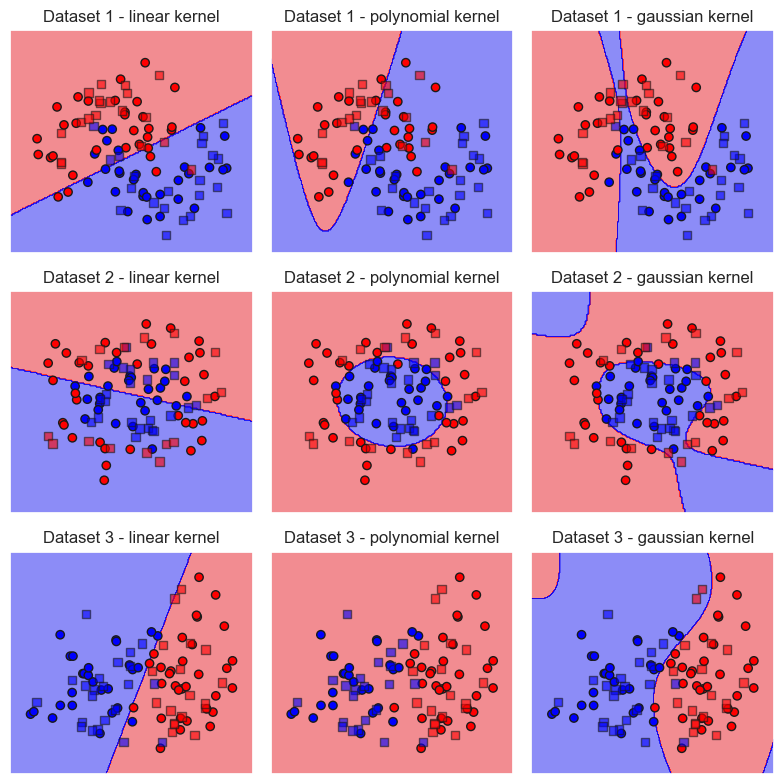

In [ ]:
names = [
    "linear",
    "polynomial",
    "gaussian",
]
classifiers = [
    logistic(linear_kernel),
    logistic(polynomial_kernel),
    logistic(gaussian_kernel)
]
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)
datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]
fig, axs = plt.subplots(len(datasets), len(classifiers), figsize=(8, 8))
for i, ds in enumerate(datasets):
  X_train, X_test, y_train, y_test = train_test_split(ds[0], ds[1], test_size=0.4, random_state=42)
  for j, (name, clf) in enumerate(zip(names, classifiers)):
    ax = axs[i, j]
    if i == 0:
        ax.set_title(name)
    clf.fit(X_train, y_train)
    plot_decision_boundary(ax, X_train, y_train, X_test, y_test, clf, name, f'Dataset {i+1}')

plt.tight_layout()
plt.show()

The results show that the gaussian kernel had the best performance for the three datasets (moons, circles and linear-separable respectively) visually at least because of the decision region plot. Fot the polynomial kernel the results were good for the circle dataset but really bad in the other two datasets, changing the degree is a good experiment for further work. For the linear kernel the results were good for the linear dataset but not so good on the other ones.